In [1]:
import sys
import datetime as dt
import pandas as pd
import numpy as np
import scipy.stats  as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Load Data

In [2]:
df = pd.read_csv(config.dataFol+'all_cleaned_wsp_sonyc_birds_by_hour.csv')

### 2. Processing Data
* convert timestamps from UTC to US/Eastern

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp_utc']) \
    .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df['year'] = pd.DatetimeIndex(df['timestamp']).year
df['month'] = pd.DatetimeIndex(df['timestamp']).month
df['day'] = pd.DatetimeIndex(df['timestamp']).day
df['hour'] = pd.DatetimeIndex(df['timestamp']).hour

In [4]:
df.shape

(84894, 33)

In [5]:
df.head()

timestamp_utc sonyc_sensor_id           sonyc_sensor_name  \
0  2017-03-01 00:00    b827eb815321  19 Washington Square North   
1  2017-03-01 00:00             NaN                         NaN   
2  2017-03-01 00:00             NaN                         NaN   
3  2017-03-01 00:00             NaN                         NaN   
4  2017-03-01 00:00    b827eb86d458                  Silver lab   

   dBAS_lin_mean         l1        l10         l5        l90  \
0      62.712239  68.846158  65.941533  66.922908  56.441534   
1            NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN   
3            NaN        NaN        NaN        NaN        NaN   
4      65.063373  72.444738  67.272633  68.893466  59.510567   

   count_of_positive_predictions  pct_positive_predictions  ...  \
0                            0.0                       0.0  ...   
1                            NaN                       NaN  ...   
2                            NaN                       NaN  ...   
3                            NaN                       NaN  ...   
4                            NaN                       NaN  ...   

   s_19WashingtonSquareNorth  s_juanCarlos  s_shimkinReadingRoom  \
0                          1             0                     0   
1                          0             0                     0   
2                          0             0                     0   
3                          0             0                     0   
4                          0             0                     0   

   s_4WashingtonSquareNorth  s_kimmelCenter                 timestamp  year  \
0                         0               0 2017-02-28 19:00:00-05:00  2017   
1                         0               0 2017-02-28 19:00:00-05:00  2017   
2                         0               0 2017-02-28 19:00:00-05:00  2017   
3                         0               0 2017-02-28 19:00:00-05:00  2017   
4                         0               0 2017-02-28 19:00:00-05:00  2017   

   month  day  hour  
0      2   28    19  
1      2   28    19  
2      2   28    19  
3      2   28    19  
4      2   28    19  

[5 rows x 33 columns]

In [6]:
df.dtypes

timestamp_utc                                        object
sonyc_sensor_id                                      object
sonyc_sensor_name                                    object
dBAS_lin_mean                                       float64
l1                                                  float64
l10                                                 float64
l5                                                  float64
l90                                                 float64
count_of_positive_predictions                       float64
pct_positive_predictions                            float64
avg_mtr_#/km/h                                      float64
avg_mt_#/km                                         float64
avg_height_m                                        float64
temp_celcius                                        float64
dewp_celcius                                        float64
rh_percentage                                       float64
wind_dir                                

In [7]:
df.sonyc_sensor_name.unique()

array(['19 Washington Square North', nan, 'Silver lab', 'Juan Carlos',
       'Shimkin Reading Room', '4 Washington Square North',
       'Kimmel Center'], dtype=object)

In [8]:
df.shape

(84894, 33)

### 3. Examining YAMNet Data
* find the sonyc sensor name for easy comprehension


In [9]:
yamnetByHour = df[['sonyc_sensor_name', 'pct_positive_predictions',
                       'year', 'month', 'day', 'hour', 'timestamp']].drop_duplicates()
yamnetByHour = yamnetByHour[(yamnetByHour.month >=3) & (yamnetByHour.month <=5)]
yamnetByHour['datetime'] = pd.to_datetime(yamnetByHour.timestamp)
yamnetByHour.head()

sonyc_sensor_name  pct_positive_predictions  year  month  day  \
50  19 Washington Square North                   0.00000  2017      3    1   
51                         NaN                       NaN  2017      3    1   
54                  Silver lab                       NaN  2017      3    1   
58                 Juan Carlos                   0.08333  2017      3    1   
59        Shimkin Reading Room                   0.00000  2017      3    1   

    hour                 timestamp                  datetime  
50     0 2017-03-01 00:00:00-05:00 2017-03-01 00:00:00-05:00  
51     0 2017-03-01 00:00:00-05:00 2017-03-01 00:00:00-05:00  
54     0 2017-03-01 00:00:00-05:00 2017-03-01 00:00:00-05:00  
58     0 2017-03-01 00:00:00-05:00 2017-03-01 00:00:00-05:00  
59     0 2017-03-01 00:00:00-05:00 2017-03-01 00:00:00-05:00

### 4. pct_positive_predictions by sensor by month by hour

In [10]:
yamnetMonthly = yamnetByHour.groupby(['sonyc_sensor_name','year','month','hour']) \
    .agg(['mean', 'std']).reset_index()
yamnetMonthly['hour_est'] = yamnetMonthly.hour.astype(float)
yamnetMonthly.columns = ["_".join(x) for x in yamnetMonthly.columns.ravel()]
yamnetMonthly.rename(columns={'sonyc_sensor_name_':'sensor', 'year_':'year', 
                             'month_':'month', 'hour_est_':'hour_est',
                             'hour_':'hour'}, inplace=True)
yamnetMonthly.head()

sensor  year  month  hour  \
0  19 Washington Square North  2017      3     0   
1  19 Washington Square North  2017      3     1   
2  19 Washington Square North  2017      3     2   
3  19 Washington Square North  2017      3     3   
4  19 Washington Square North  2017      3     4   

   pct_positive_predictions_mean  pct_positive_predictions_std   day_mean  \
0                       0.000000                      0.000000  16.000000   
1                       0.012630                      0.032425  16.000000   
2                       0.023180                      0.031289  16.133333   
3                       0.029075                      0.038015  16.000000   
4                       0.043139                      0.044035  16.000000   

    day_std  hour_est  
0  9.092121       0.0  
1  9.092121       1.0  
2  9.216677       2.0  
3  9.092121       3.0  
4  9.092121       4.0

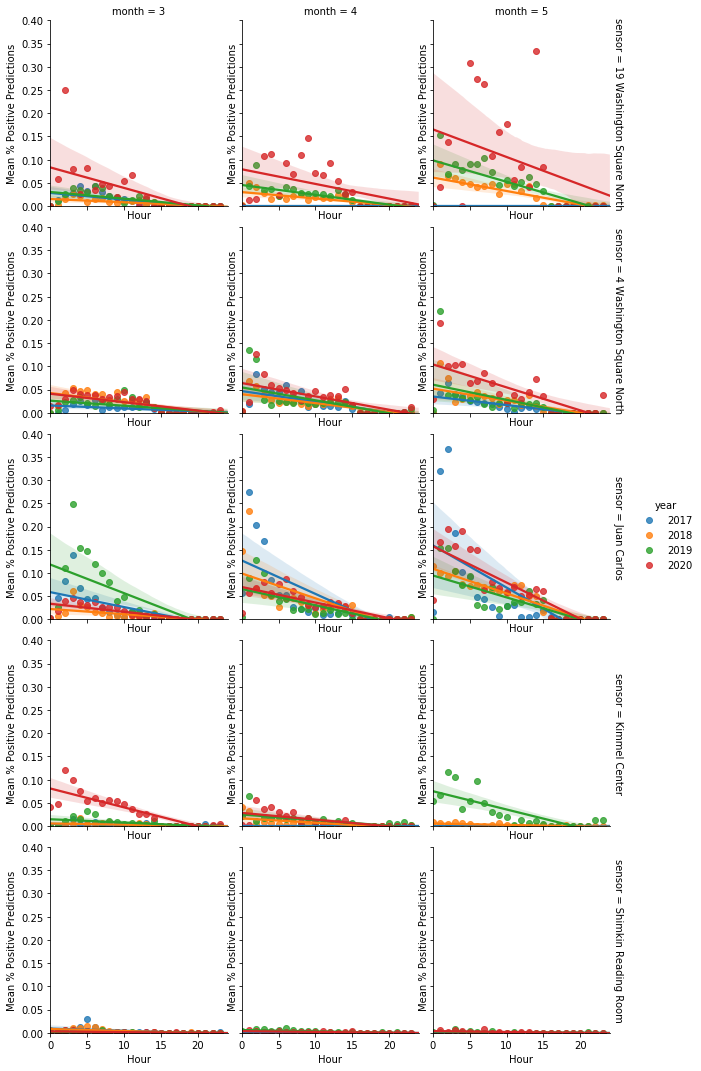

In [11]:
g = sns.FacetGrid(yamnetMonthly[yamnetMonthly.sensor != 'Silver lab'],
                  row='sensor', 
                  col="month", hue='year', ylim=(0, 0.4), xlim=(0,24),
                  margin_titles=True)
g.map(sns.regplot, "hour_est", "pct_positive_predictions_mean")
g.set(xlabel='Hour', ylabel='Mean % Positive Predictions')
g.add_legend()
g.savefig("../figures/yamnet_avg_by_hour.png")

#### Figure 1: Scatter Plot of the hour in est vs mean pct positive predictions for the hour

### 5. Looking at Correlation for `pct_positive_predictions` and `avg_mtr_#/km/h`

In [12]:
cols = ['pct_positive_predictions', 'avg_mtr_#/km/h']

dfList = dict(list(df.groupby('sonyc_sensor_name')))
for key in dfList.keys():
    dfList[key].set_index('timestamp', inplace=True)

19 Washington Square North
4 Washington Square North
Juan Carlos
Kimmel Center
Shimkin Reading Room
Silver lab


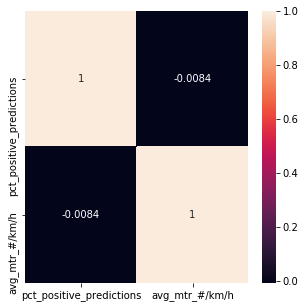

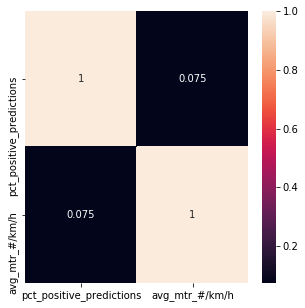

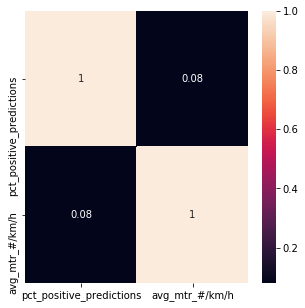

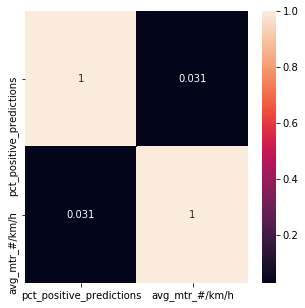

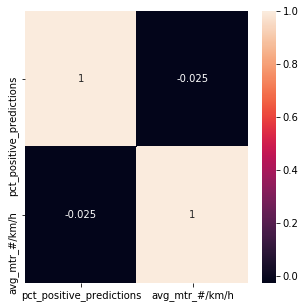

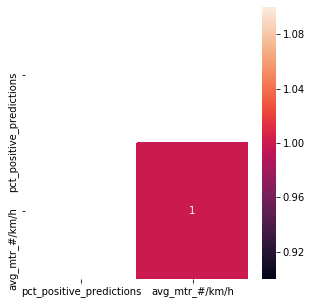

In [13]:
for key in dfList.keys():
    corrMatrix = dfList[key][cols].corr()
    plt.figure(figsize=(5,5))
    print(key)
    sns.heatmap(corrMatrix, annot=True)

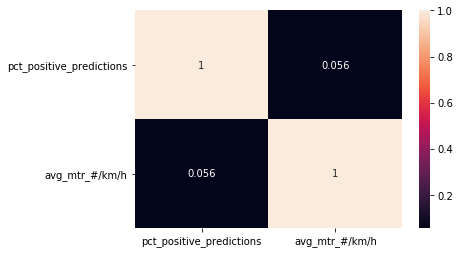

In [14]:
sns.heatmap(df[cols].corr(), annot=True)

#### Excluding the Non as Birdy Sensors and limiting to the hours of 4am to 8am 

In [15]:
birdy_df = df[(df.hour >=4) & (df.hour <=8) & 
              (df.sonyc_sensor_name!='Shimkin Reading Room') & (df.sonyc_sensor_name!='Silver lab')][['dBAS_lin_mean',
            'l1', 'l10', 'l5', 'l90', 'count_of_positive_predictions',
           'pct_positive_predictions', 'avg_mtr_#/km/h', 'avg_mt_#/km',
           'avg_height_m', 'temp_celcius', 'dewp_celcius', 'rh_percentage',
           'wind_dir', 'wind_speed_mph', 'sea_level_pressure_mb',
           'precipitation_mm', 'visibility_miles', 'gust_mph','peak_wind_gust_mph',
            'year', 'month', 'day', 'hour',
            's_19WashingtonSquareNorth', 's_juanCarlos', 
            's_4WashingtonSquareNorth', 's_kimmelCenter']]

In [16]:
birdy_df.columns

Index(['dBAS_lin_mean', 'l1', 'l10', 'l5', 'l90',
       'count_of_positive_predictions', 'pct_positive_predictions',
       'avg_mtr_#/km/h', 'avg_mt_#/km', 'avg_height_m', 'temp_celcius',
       'dewp_celcius', 'rh_percentage', 'wind_dir', 'wind_speed_mph',
       'sea_level_pressure_mb', 'precipitation_mm', 'visibility_miles',
       'gust_mph', 'peak_wind_gust_mph', 'year', 'month', 'day', 'hour',
       's_19WashingtonSquareNorth', 's_juanCarlos', 's_4WashingtonSquareNorth',
       's_kimmelCenter'],
      dtype='object')

In [17]:
rho = birdy_df.corr() # get the corr coefs

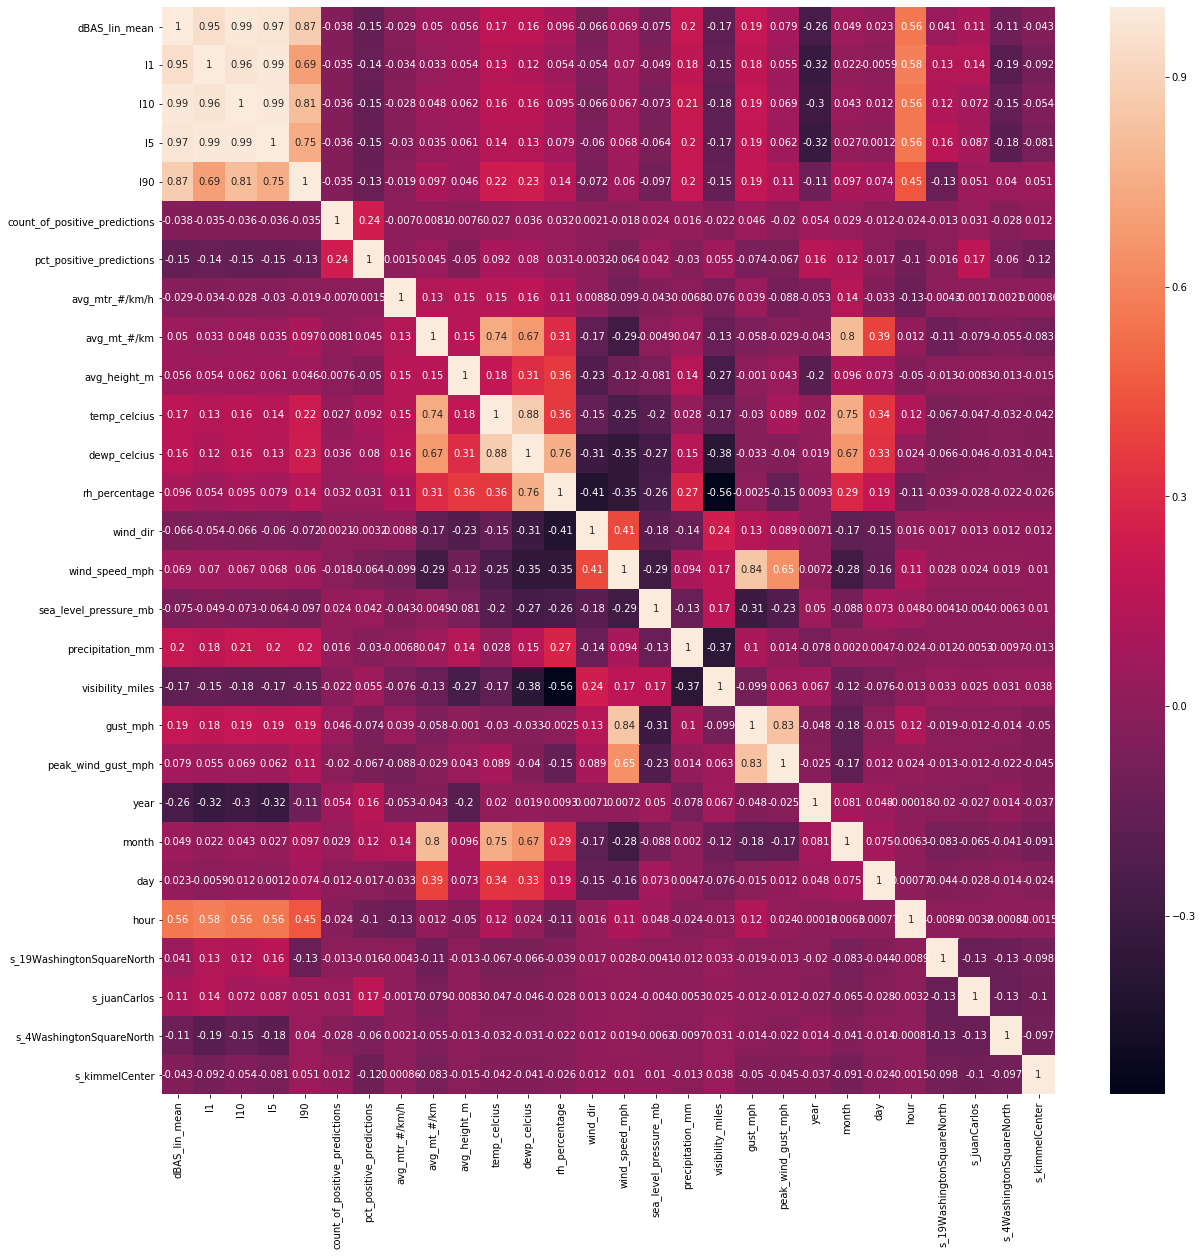

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(rho, annot=True)
plt.savefig("../figures/all_metrics_corr.png")

#### Figure XX: Correlation Matrix of the Features in Dataframe Including only the Birdy Sensors and limited to the hours of 4am and 8am

In [19]:
pval = birdy_df.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.astype(str) + p

dBAS_lin_mean  \
dBAS_lin_mean                                   1.0***   
l1                               0.9477335872192525***   
l10                              0.9862951188703494***   
l5                               0.9703208882432589***   
l90                              0.8740449873957653***   
count_of_positive_predictions   -0.03825730172265751**   
pct_positive_predictions       -0.15137853500961965***   
avg_mtr_#/km/h                 -0.028885162082314734**   
avg_mt_#/km                    0.050329114120460844***   
avg_height_m                    0.05553731372792435***   
temp_celcius                    0.16853489021718554***   
dewp_celcius                     0.1635392504658762***   
rh_percentage                   0.09563337069622145***   
wind_dir                       -0.06638094253177763***   
wind_speed_mph                  0.06885127828453566***   
sea_level_pressure_mb          -0.07494212335828014***   
precipitation_mm                 0.2012036267568562***   
visibility_miles                -0.1672742239986968***   
gust_mph                        0.19260314266900078***   
peak_wind_gust_mph                  0.079191933125538*   
year                            -0.2579947573798966***   
month                          0.049426443071257736***   
day                              0.023188929268049524*   
hour                             0.5578945040791208***   
s_19WashingtonSquareNorth       0.04136489100101497***   
s_juanCarlos                    0.10632723013928279***   
s_4WashingtonSquareNorth       -0.11485511306575764***   
s_kimmelCenter                 -0.04282181882141987***   

                                                    l1  \
dBAS_lin_mean                    0.9477335872192525***   
l1                                              1.0***   
l10                              0.9637229176435231***   
l5                               0.9863440539872725***   
l90                              0.6931357343322825***   
count_of_positive_predictions  -0.035386459629774186**   
pct_positive_predictions        -0.1387748138938884***   
avg_mtr_#/km/h                 -0.03388500608762118***   
avg_mt_#/km                     0.03288043287431426***   
avg_height_m                   0.054086339962232305***   
temp_celcius                     0.1316842056953169***   
dewp_celcius                    0.11631950584078064***   
rh_percentage                   0.05405163413132709***   
wind_dir                       -0.05394735737386259***   
wind_speed_mph                  0.06998342744674935***   
sea_level_pressure_mb          -0.04876796040197177***   
precipitation_mm                0.17751615384557778***   
visibility_miles               -0.15124445423171431***   
gust_mph                        0.17873864790239752***   
peak_wind_gust_mph                 0.05466875678272506   
year                            -0.3197637225156051***   
month                            0.021658537976390318*   
day                              -0.005907933262349486   
hour                             0.5811339148906528***   
s_19WashingtonSquareNorth       0.12863764062532937***   
s_juanCarlos                    0.13587564423923615***   
s_4WashingtonSquareNorth       -0.19178507389525343***   
s_kimmelCenter                 -0.09224927199222205***   

                                                   l10  \
dBAS_lin_mean                    0.9862951188703494***   
l1                               0.9637229176435231***   
l10                                             1.0***   
l5                               0.9912189614552431***   
l90                               0.814946200841004***   
count_of_positive_predictions   -0.03614346178317847**   
pct_positive_predictions        -0.1490989805914324***   
avg_mtr_#/km/h                  -0.02826774434653447**   
avg_mt_#/km                     0.04775941320110018***   
avg_height_m                    0.06247644804712206***   
temp_celcius                    0.159

In [20]:
pd.DataFrame({'rho': rho.pct_positive_predictions,
              'pval': round(pval.pct_positive_predictions, 4),
              'significance': p.pct_positive_predictions})

rho    pval significance
dBAS_lin_mean                 -0.151379  0.0000          ***
l1                            -0.138775  0.0000          ***
l10                           -0.149099  0.0000          ***
l5                            -0.146291  0.0000          ***
l90                           -0.132538  0.0000          ***
count_of_positive_predictions  0.236765  0.0000          ***
pct_positive_predictions       1.000000  0.0000          ***
avg_mtr_#/km/h                 0.001464  0.9295             
avg_mt_#/km                    0.045171  0.0063          ***
avg_height_m                  -0.049612  0.0027          ***
temp_celcius                   0.091600  0.0000          ***
dewp_celcius                   0.080128  0.0000          ***
rh_percentage                  0.031029  0.0607            *
wind_dir                      -0.003226  0.8455             
wind_speed_mph                -0.064368  0.0001          ***
sea_level_pressure_mb          0.042227  0.0107           **
precipitation_mm              -0.030192  0.0840            *
visibility_miles               0.055168  0.0008          ***
gust_mph                      -0.074152  0.0774            *
peak_wind_gust_mph            -0.067165  0.2023             
year                           0.155273  0.0000          ***
month                          0.119960  0.0000          ***
day                           -0.017168  0.2993             
hour                          -0.102106  0.0000          ***
s_19WashingtonSquareNorth     -0.016148  0.3289             
s_juanCarlos                   0.168413  0.0000          ***
s_4WashingtonSquareNorth      -0.059662  0.0003          ***
s_kimmelCenter                -0.118423  0.0000          ***

In [21]:
rho.pct_positive_predictions.sort_values()

dBAS_lin_mean                   -0.151379
l10                             -0.149099
l5                              -0.146291
l1                              -0.138775
l90                             -0.132538
s_kimmelCenter                  -0.118423
hour                            -0.102106
gust_mph                        -0.074152
peak_wind_gust_mph              -0.067165
wind_speed_mph                  -0.064368
s_4WashingtonSquareNorth        -0.059662
avg_height_m                    -0.049612
precipitation_mm                -0.030192
day                             -0.017168
s_19WashingtonSquareNorth       -0.016148
wind_dir                        -0.003226
avg_mtr_#/km/h                   0.001464
rh_percentage                    0.031029
sea_level_pressure_mb            0.042227
avg_mt_#/km                      0.045171
visibility_miles                 0.055168
dewp_celcius                     0.080128
temp_celcius                     0.091600
month                            0

#### Correlation (rho and p-values) of the correlation table

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


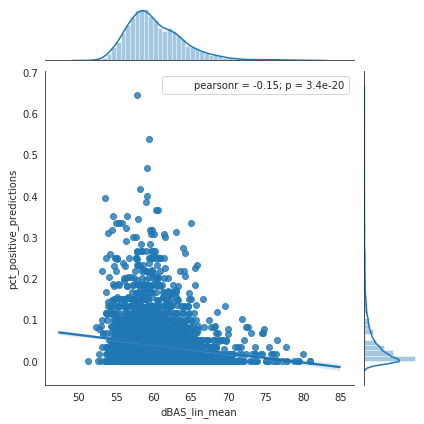

In [22]:
with sns.axes_style('white'):
    sns.jointplot("dBAS_lin_mean", "pct_positive_predictions",
                  data=birdy_df[["pct_positive_predictions",'dBAS_lin_mean']],
                  kind='reg').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


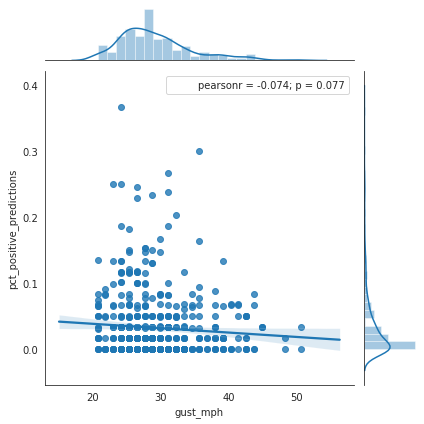

In [23]:
with sns.axes_style('white'):
    sns.jointplot("gust_mph", "pct_positive_predictions",
                  data=birdy_df[['gust_mph','pct_positive_predictions']],
                  kind='reg').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


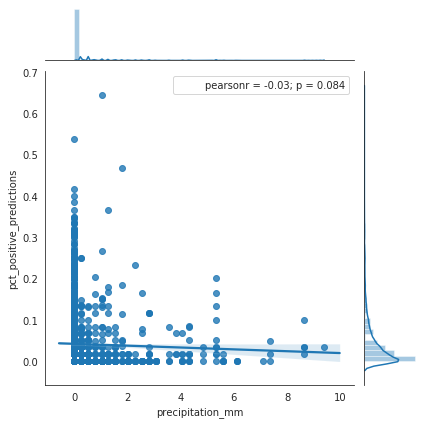

In [24]:
with sns.axes_style('white'):
    sns.jointplot("precipitation_mm", "pct_positive_predictions",
                  data=birdy_df[['precipitation_mm','pct_positive_predictions']], 
                  kind='reg').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


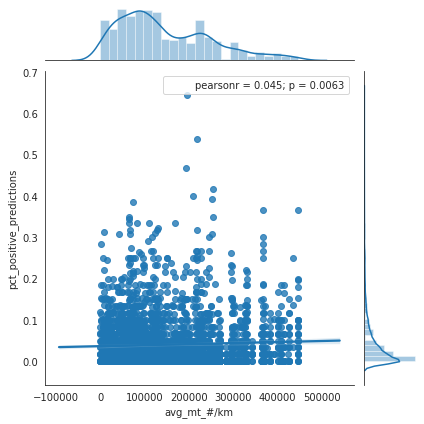

In [25]:
with sns.axes_style('white'):
    sns.jointplot("avg_mt_#/km", "pct_positive_predictions",
                  data=birdy_df[["pct_positive_predictions",'avg_mt_#/km']],
                  kind='reg').annotate(stats.pearsonr)

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


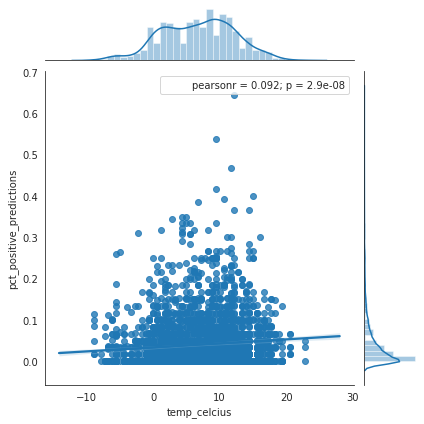

In [26]:
with sns.axes_style('white'):
    sns.jointplot("temp_celcius", "pct_positive_predictions",
                  data=birdy_df[["pct_positive_predictions",'temp_celcius']],
                  kind='reg').annotate(stats.pearsonr)

### 6. Inspecting the trends in timeseries

Detrend by Differencing

In [27]:
birdy_dfList = df[(df.hour >=4) & (df.hour <=8) & (df.sonyc_sensor_name!='Shimkin Reading Room') &
                  (df.sonyc_sensor_name!='Silver lab')][['timestamp', 'dBAS_lin_mean',
            'l1', 'l10', 'l5', 'l90', 'count_of_positive_predictions',
           'pct_positive_predictions', 'avg_mtr_#/km/h', 'avg_mt_#/km',
           'avg_height_m', 'temp_celcius', 'dewp_celcius', 'rh_percentage',
           'wind_dir', 'wind_speed_mph', 'sea_level_pressure_mb',
           'precipitation_mm', 'visibility_miles', 'gust_mph',
           'peak_wind_gust_mph', 'sonyc_sensor_name', 'year', 'month', 'day', 'hour']]
birdy_dfList = dict(list(birdy_dfList.groupby('sonyc_sensor_name')))
# set datetime as index
for key in birdy_dfList:
    birdy_dfList[key] = birdy_dfList[key].set_index(pd.DatetimeIndex(birdy_dfList[key].timestamp))

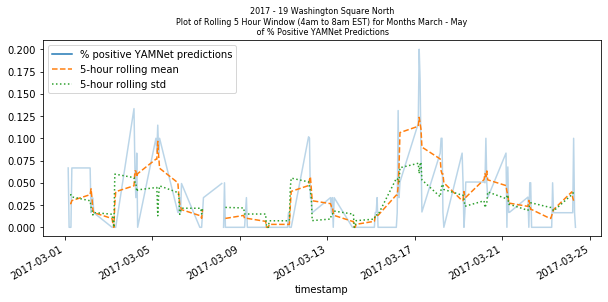

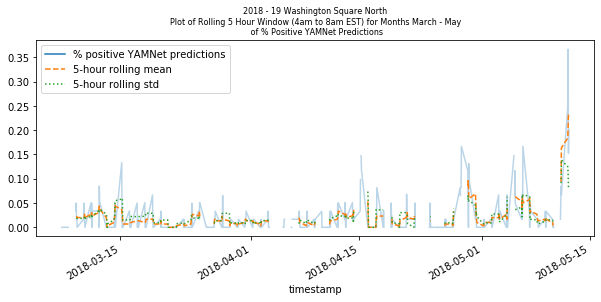

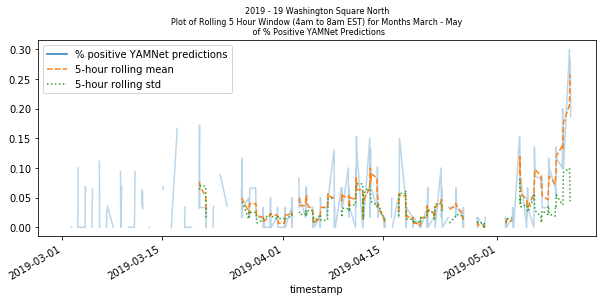

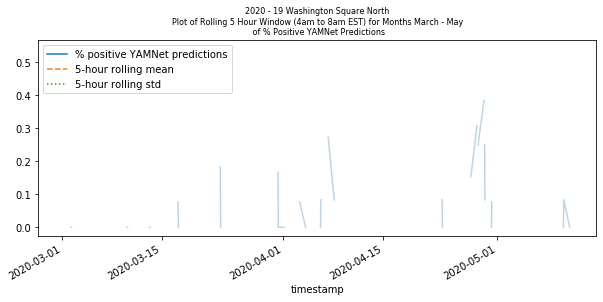

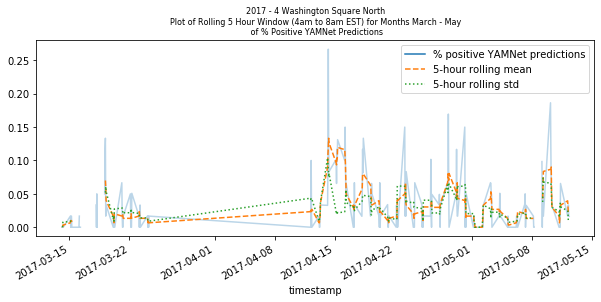

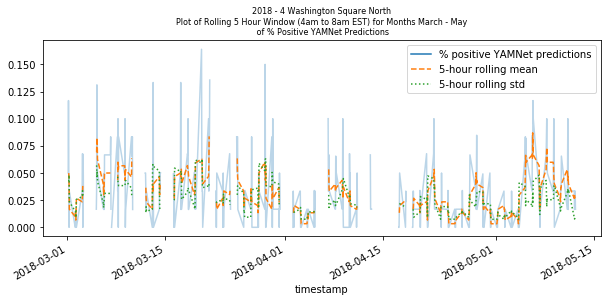

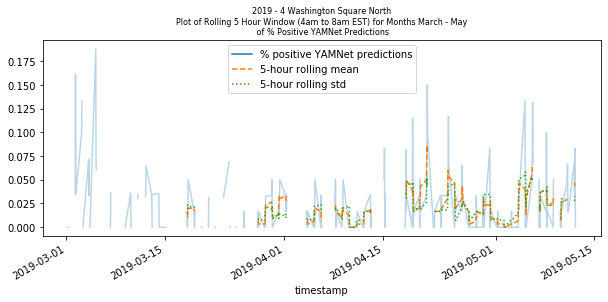

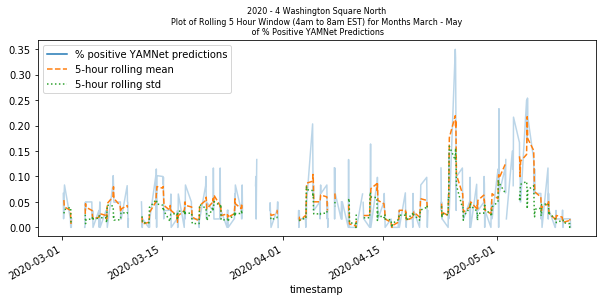

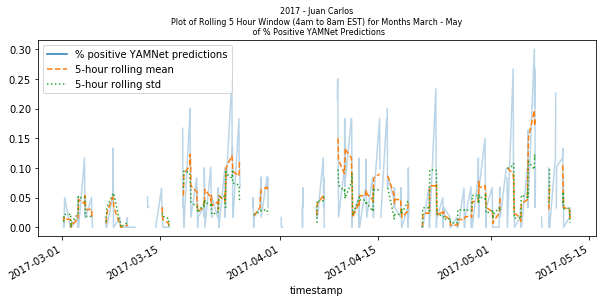

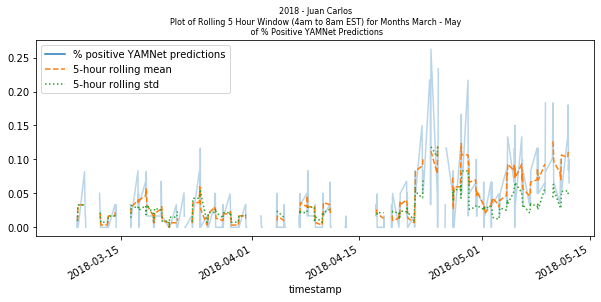

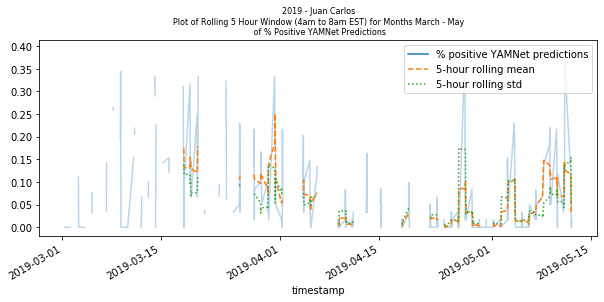

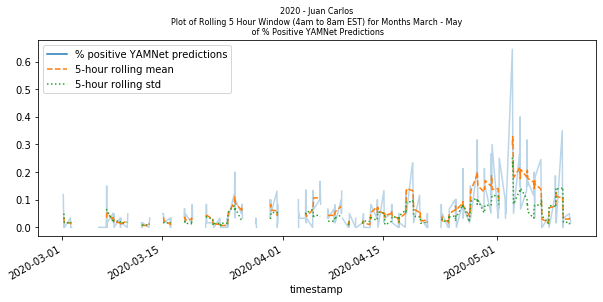

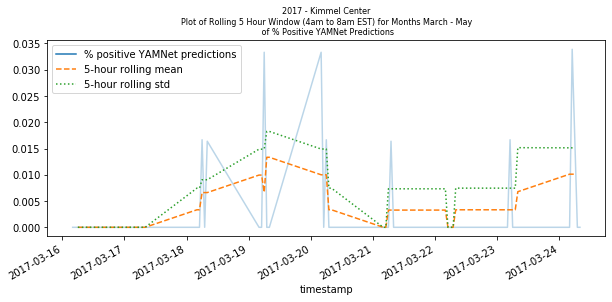

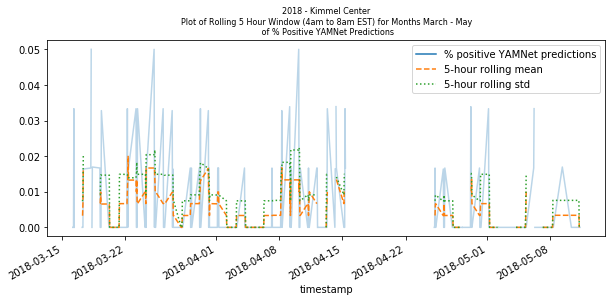

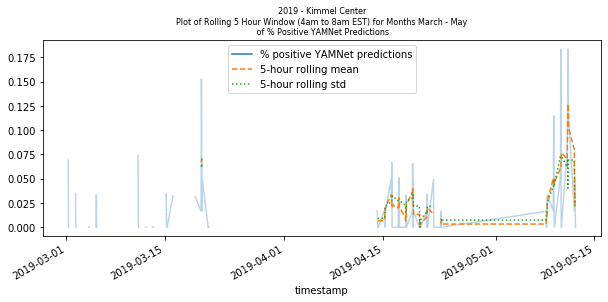

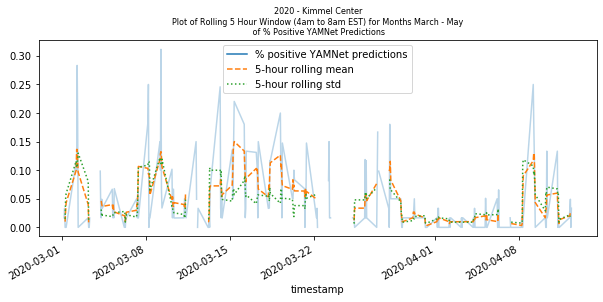

In [28]:
years = [2017, 2018, 2019, 2020]
for key in birdy_dfList:
    for y in years:
        temp = birdy_dfList[key][(birdy_dfList[key].year==y)]['pct_positive_predictions']
        rolling = temp.rolling(5, center=True)
        data = pd.DataFrame({'% positive YAMNet predictions': temp, 
                    '5-hour rolling mean':rolling.mean(), 
                    '5-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,4))
        ax.lines[0].set_alpha(0.3)
        plt.title(str(y) +" - "+ key + "\nPlot of Rolling 5 Hour Window (4am to 8am EST) for Months March - May\n"+
                 " of % Positive YAMNet Predictions", fontsize=8)
        plt.savefig("../figures/"+key.replace(" ", "_")+"_"+str(y)+"_trend_pct_positive_predictions.png")

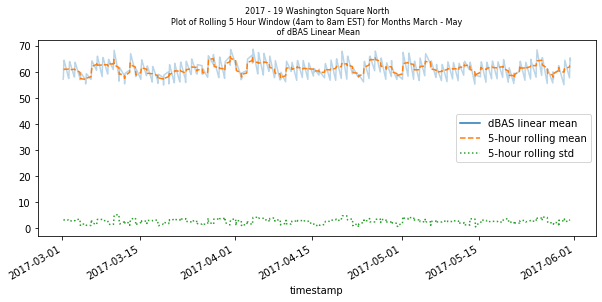

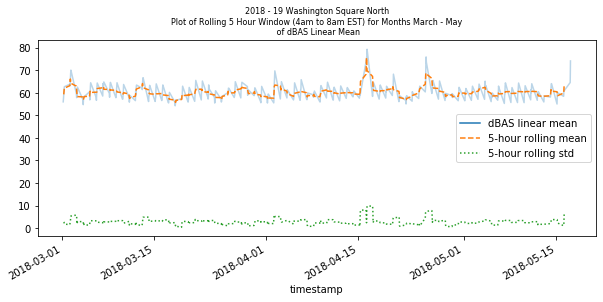

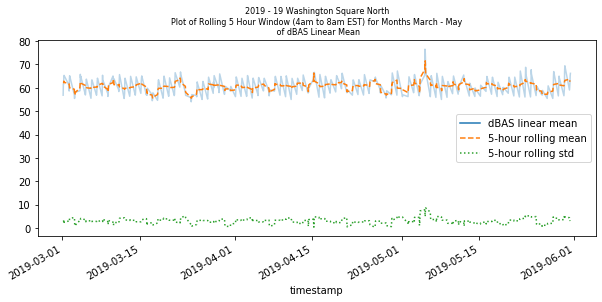

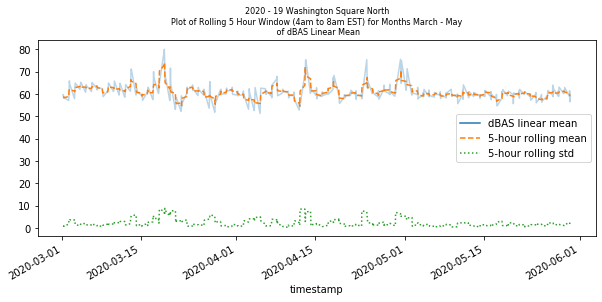

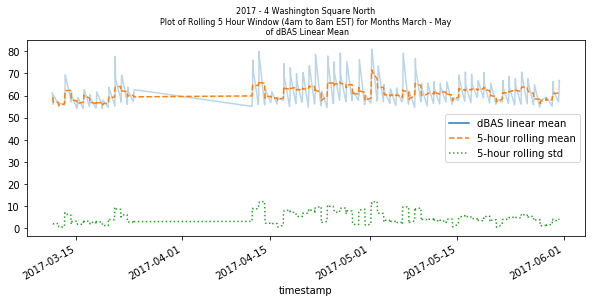

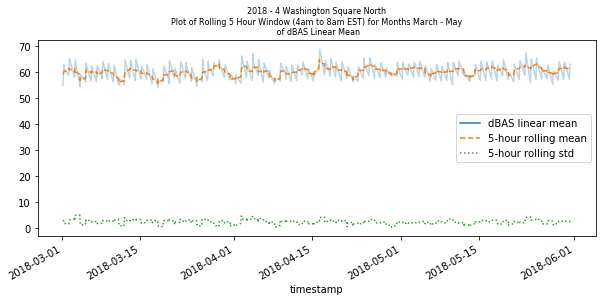

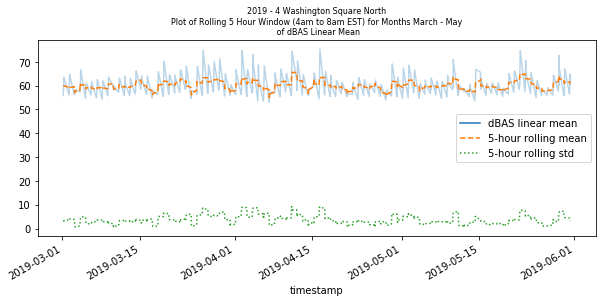

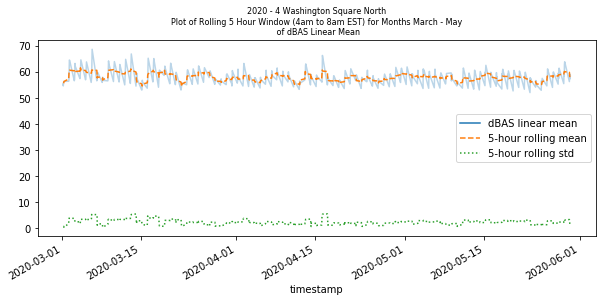

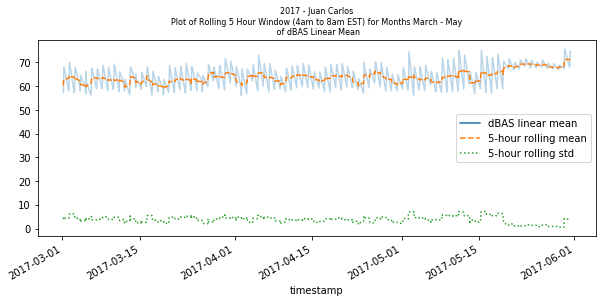

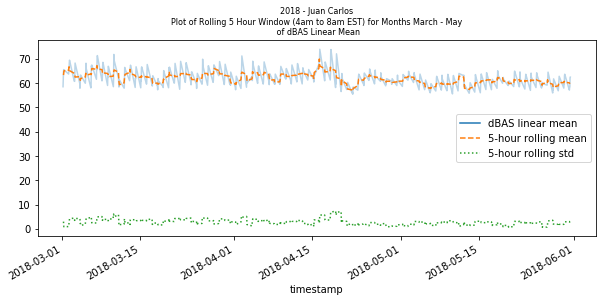

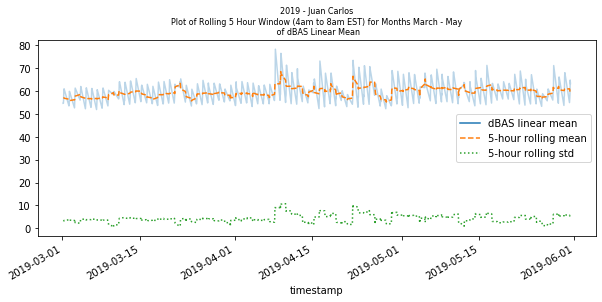

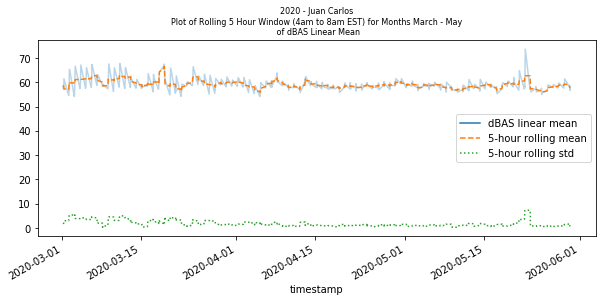

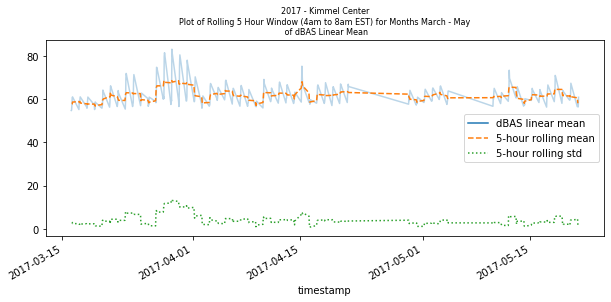

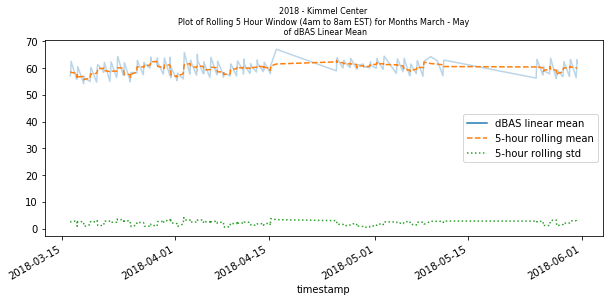

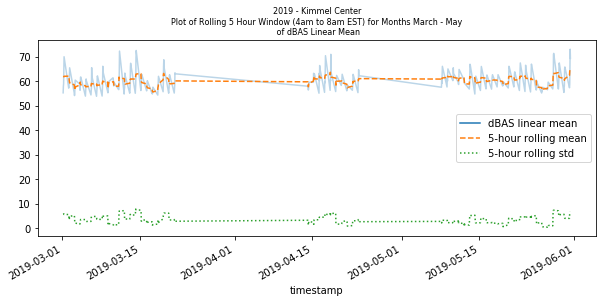

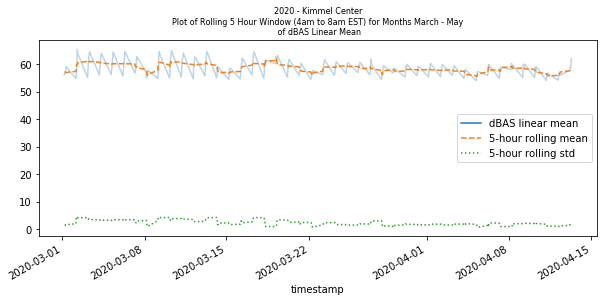

In [29]:
for key in birdy_dfList:
    for y in years:
        temp = birdy_dfList[key][(birdy_dfList[key].year==y)]['dBAS_lin_mean']
        rolling = temp.rolling(5, center=True)
        data = pd.DataFrame({'dBAS linear mean': temp, 
                    '5-hour rolling mean':rolling.mean(), 
                    '5-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,4))
        ax.lines[0].set_alpha(0.3)
        plt.title(str(y) +" - "+ key + "\nPlot of Rolling 5 Hour Window (4am to 8am EST) for Months March - May\n"+
                 " of dBAS Linear Mean", fontsize = 8)
        plt.savefig("../figures/"+key.replace(" ", "_")+"_"+str(y)+"_trend_dBAS_lin_mean.png")

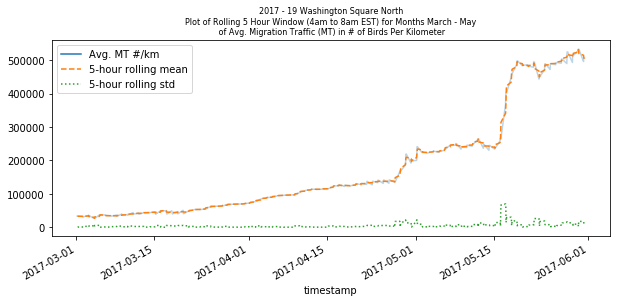

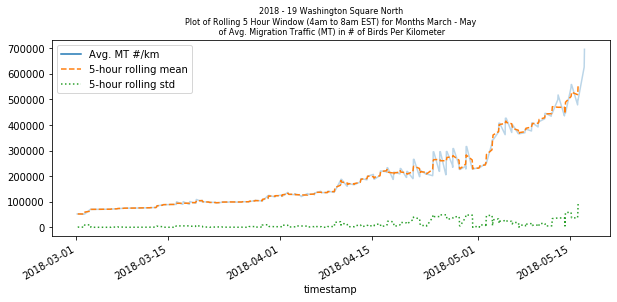

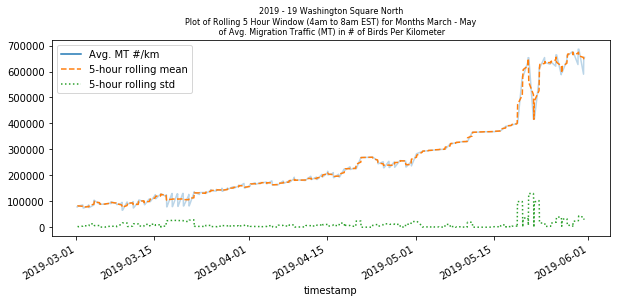

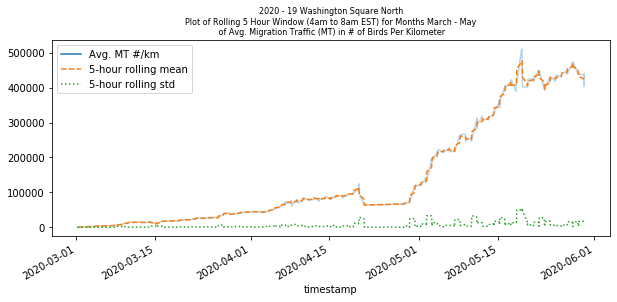

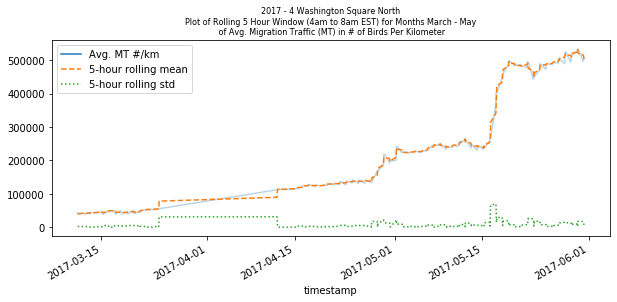

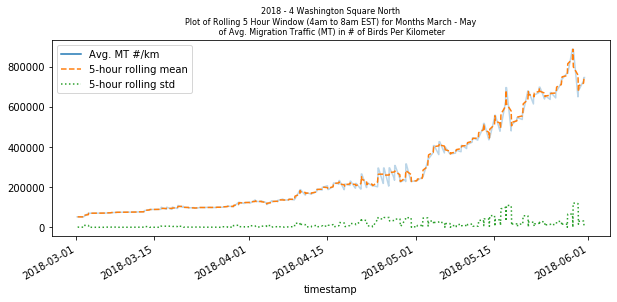

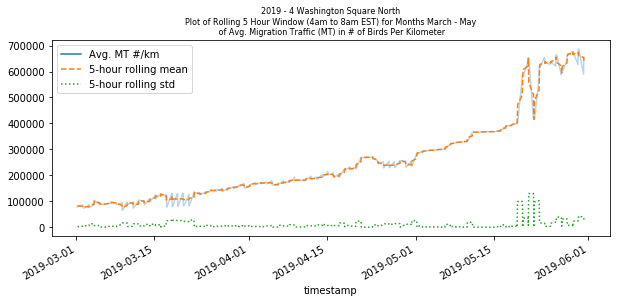

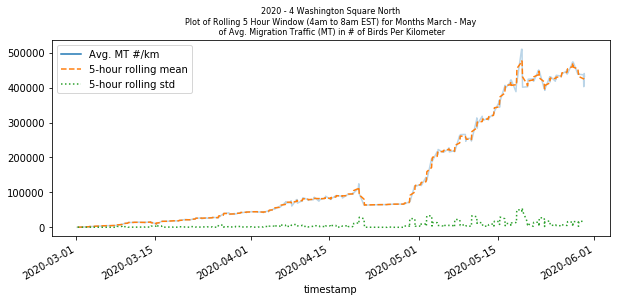

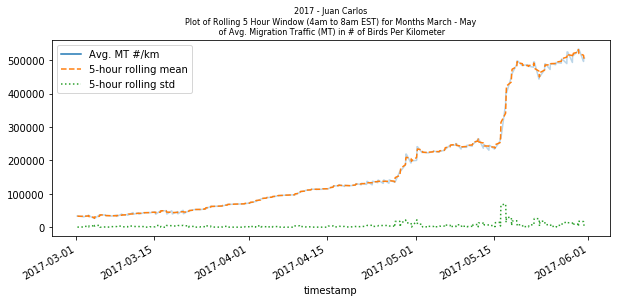

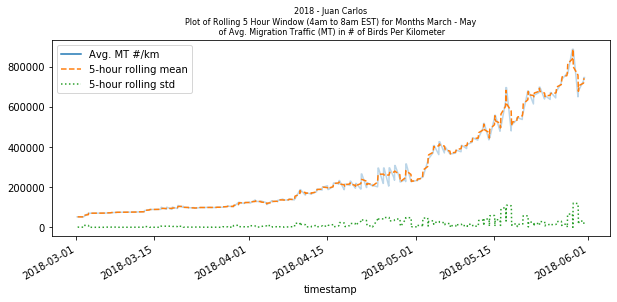

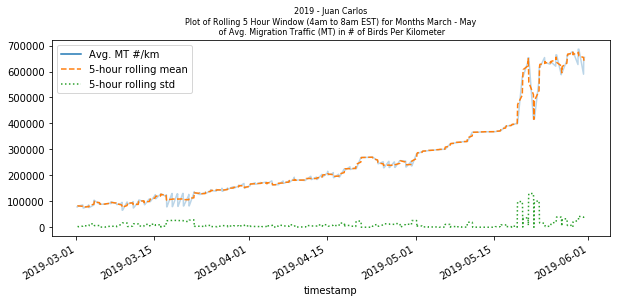

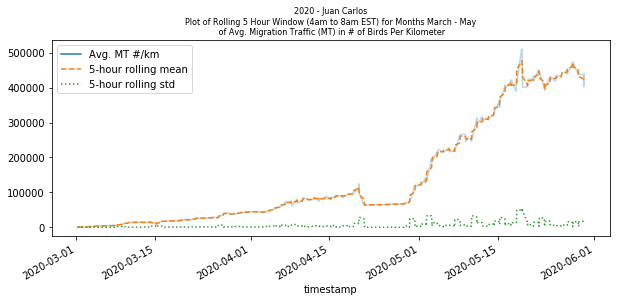

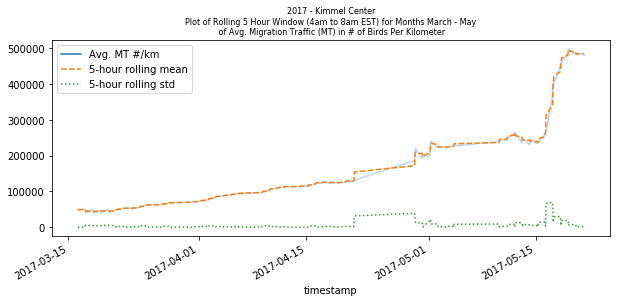

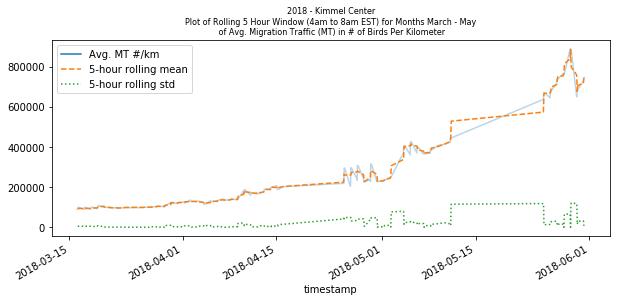

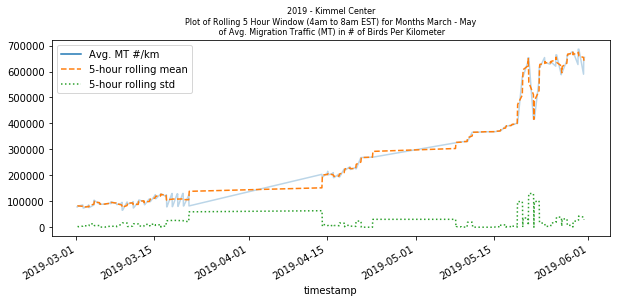

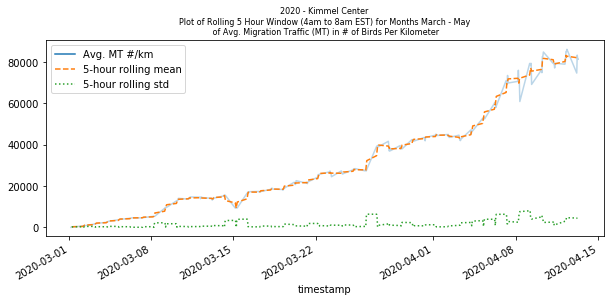

In [30]:
for key in birdy_dfList:
    for y in years:
        temp = birdy_dfList[key][(birdy_dfList[key].year==y)]['avg_mt_#/km']
        rolling = temp.rolling(5, center=True)
        data = pd.DataFrame({'Avg. MT #/km': temp, 
                    '5-hour rolling mean':rolling.mean(), 
                    '5-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,4))
        ax.lines[0].set_alpha(0.3)
        plt.title(str(y) +" - "+ key + "\nPlot of Rolling 5 Hour Window (4am to 8am EST) for Months March - May\n"+
                 " of Avg. Migration Traffic (MT) in # of Birds Per Kilometer", fontsize = 8)
        plt.savefig("../figures/"+key.replace(" ", "_")+"_"+str(y)+"_trend_avg_mt_km.png")

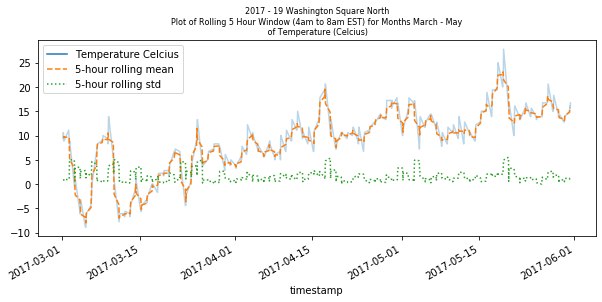

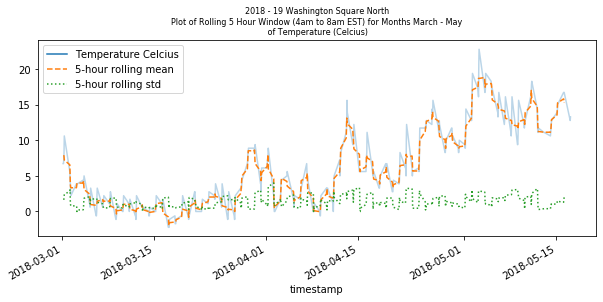

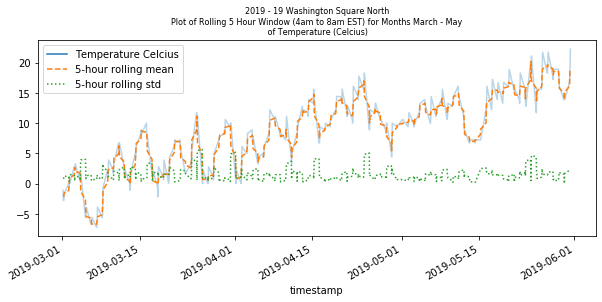

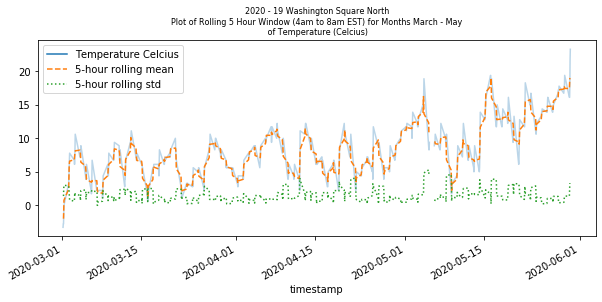

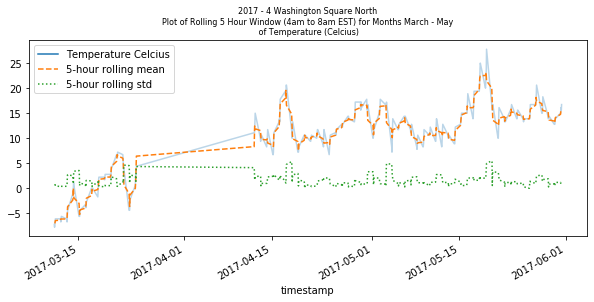

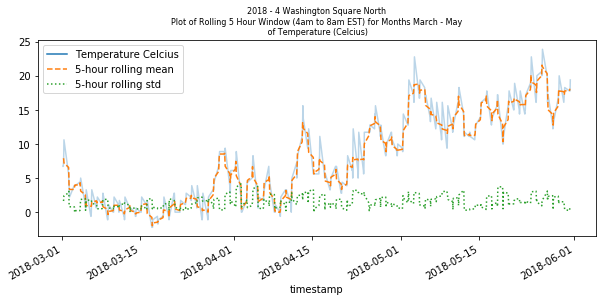

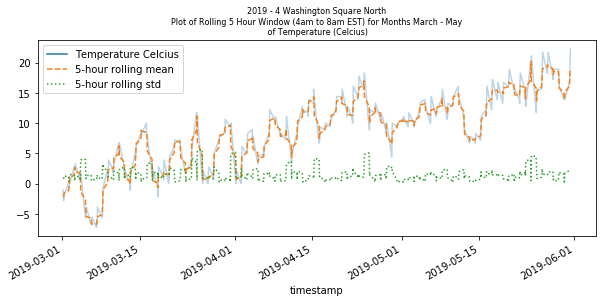

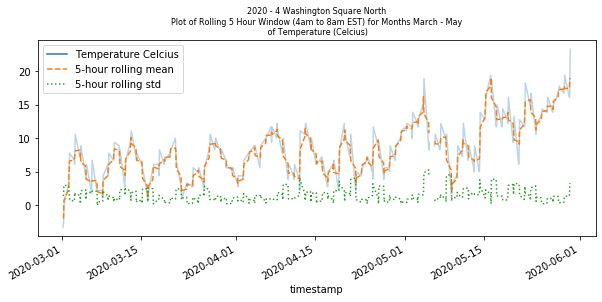

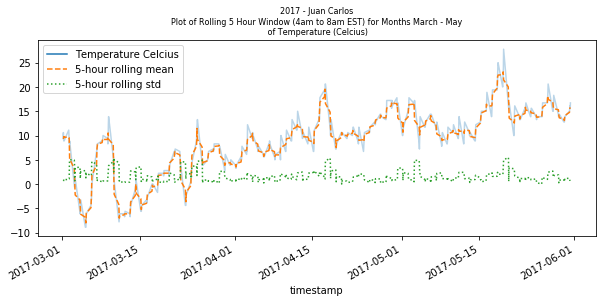

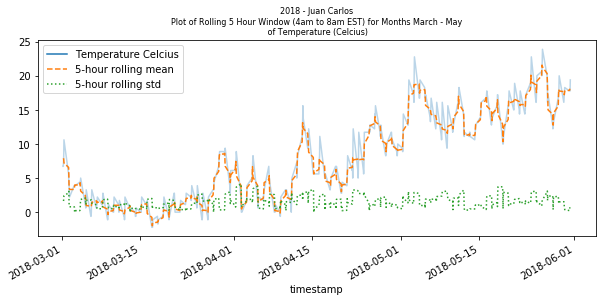

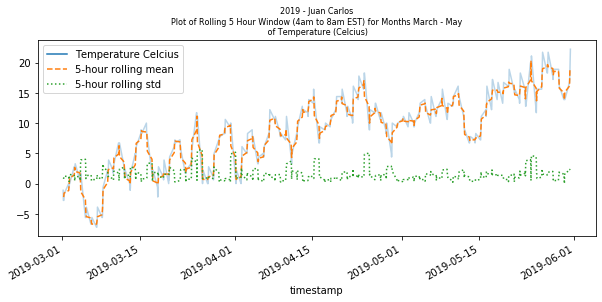

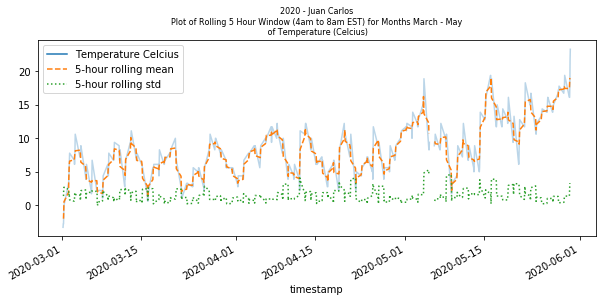

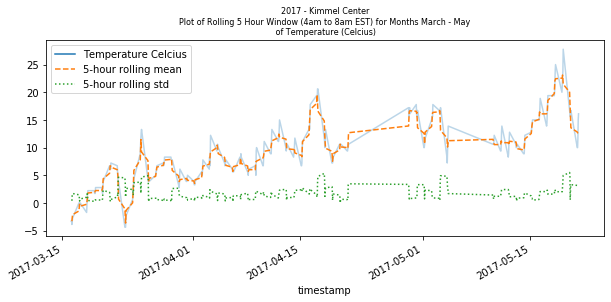

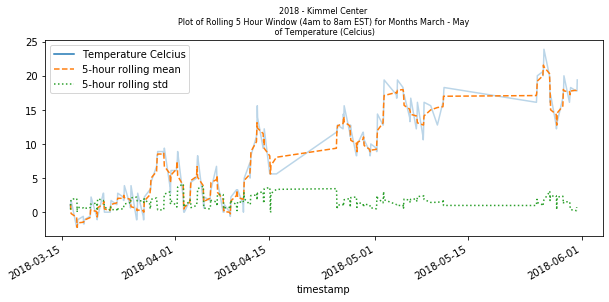

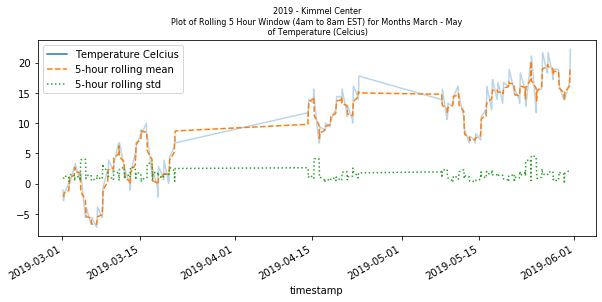

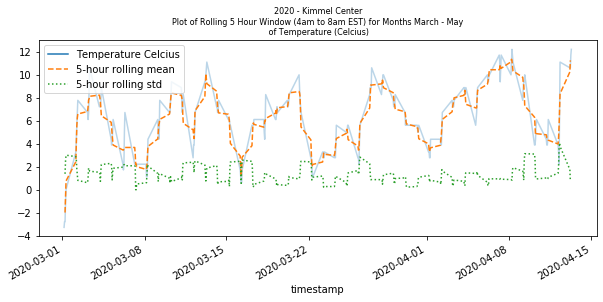

In [31]:
for key in birdy_dfList:
    for y in years:
        temp = birdy_dfList[key][(birdy_dfList[key].year==y)]['temp_celcius']
        rolling = temp.rolling(5, center=True)
        data = pd.DataFrame({'Temperature Celcius': temp, 
                    '5-hour rolling mean':rolling.mean(), 
                    '5-hour rolling std':rolling.std()})
        ax = data.plot(style=['-', '--', ':'], figsize=(10,4))
        ax.lines[0].set_alpha(0.3)
        plt.title(str(y) +" - "+ key + "\nPlot of Rolling 5 Hour Window (4am to 8am EST) for Months March - May\n"+
                 " of Temperature (Celcius)", fontsize = 8)
        plt.savefig("../figures/"+key.replace(" ", "_")+"_"+str(y)+"_trend_temp_celcius.png")